##Group Name: NLP Innovators
##Name: Naiya Patel (202211075) and Dhara Shah (202211008)
##Assignment 1: Train Word2Vec on peS2o Dataset (AllenNLP)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [ ]:
import pandas as pd
import os

!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import re
import inflect
import string

import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import re
from itertools import chain
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Loading the Data

In [ ]:
fn = '/content/drive/MyDrive/validation-00000-of-00002.json.gz'
df = pd.read_json(fn, lines=True, compression='gzip')
df

,id,source,version,added,created,text
0,254721023,s2ag/valid,v1,2022-12-16T16:07:05.559Z,2022-12-14T00:00:00.000Z,Investigation Some Characteristics of Biocompo...
1,254200673,s2ag/valid,v1,2022-12-04T16:21:43.441Z,2022-12-02T00:00:00.000Z,Modelling Techniques for Conjunctive Water Man...
2,252643161,s2ag/valid,v1,2022-10-01T15:18:53.788Z,2022-12-01T00:00:00.000Z,Complete Targets Coverage in Energy Harvesting...
3,244852373,s2ag/valid,v1,2021-12-04T16:21:39.980Z,2022-12-01T00:00:00.000Z,Nonorthogonal Multiple Access Enabled Two-Way ...
4,254774363,s2ag/valid,v1,2022-12-17T16:19:10.635Z,2022-12-14T00:00:00.000Z,106 A CASE OF COMPLETE ATRIOVENTRICULAR BLOCK ...
...,...,...,...,...,...,...
111223,254393835,s2ag/valid,v1,2022-12-08T16:07:54.109Z,2022-12-05T00:00:00.000Z,On the Death of Diversity Jurisdiction: An Emp...
111224,254122749,s2ag/valid,v1,2022-12-02T06:17:23.245Z,2022-12-01T00:00:00.000Z,"""Electron Complementation""-Induced Molybdenum ..."
111225,254805941,s2ag/valid,v1,2022-12-18T16:13:29.904Z,2022-12-16T00:00:00.000Z,An Innovative Adaptation of an HIV Status-Neut...
111226,254613890,s2ag/valid,v1,2022-12-14T16:21:33.760Z,2022-12-12T00:00:00.000Z,DNA barcoding unveils a high diversity of cadd...


## Creating Training Data

In [ ]:
sample_df = df.sample(n=3000, random_state=42)
sample_df = sample_df.reset_index(drop=True)
sample_df

,id,source,version,added,created,text
0,254806831,s2ag/valid,v1,2022-12-18T16:08:29.251Z,2022-12-01T00:00:00.000Z,On the thermal and mechanical properties of Mg...
1,254429958,s2ag/valid,v1,2022-12-09T16:16:54.318Z,2022-12-07T00:00:00.000Z,An NFIX-mediated regulatory network governs th...
2,252186777,s2ag/valid,v1,2022-09-12T13:50:04.929Z,2023-01-31T00:00:00.000Z,"Rapid, DNA-induced subunit exchange by DNA gyr..."
3,255090790,s2ag/valid,v1,2022-12-25T16:09:23.435Z,2022-12-23T00:00:00.000Z,The Wonder World of Complex Systems\n\nComplex...
4,255175557,s2ag/valid,v1,2022-12-28T16:01:52.981Z,2022-12-30T00:00:00.000Z,Financial tools for ensuring effective transfo...
...,...,...,...,...,...,...
2995,254312926,s2ag/valid,v1,2022-12-07T18:46:57.522Z,2022-12-01T00:00:00.000Z,DEVELOPMENT OF A MODEL FOR THE PREVENTION OF A...
2996,254493530,s2ag/valid,v1,2022-12-10T16:04:48.535Z,2022-12-08T00:00:00.000Z,Sprayability Analysis of Pristine and Enhanced...
2997,255222778,s2ag/valid,v1,2022-12-29T16:03:15.554Z,2022-12-23T00:00:00.000Z,Effect of Pouch Size on Sterilization of Ready...
2998,252932983,s2ag/valid,v1,2022-10-18T17:06:21.020Z,2023-01-01T00:00:00.000Z,"Removal of Zn, Pb, and Ni heavy metals from aq..."


## Natural Language Pre-Processing
1. Remove Stopwords
2. Remove URLs
3. Remove Punctuations
4. Remove Enumerations
5. Convert numeric to text
6. Remove Bullets
7. Covert text to lowercase
etc.

In [ ]:

def pre_process(text):

  text = text.lower()

  # Remove Stopwords
  words = nltk.word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  filtered_words = [word for word in words if word.lower() not in stop_words]
  text = ' '.join(filtered_words)

  # Remove urls
  url_pattern = r"https?://\S+|www\.\S+"
  text = re.sub(url_pattern, '', text)

  # Remove Bullets
  bullet_pattern = r'^[ \t]*[•*-]'
  text = re.sub(bullet_pattern, '', text, flags=re.MULTILINE)

  # Remove apostrophes
  text = text.replace("'", '')

  # Remove hyphens
  text = text.replace("-", '')

  # Remove enumerations from the text using regex
  enumeration_pattern = r'^\s*\d+\.\s*|\s*[a-zA-Z]\.\s*'
  text = re.sub(enumeration_pattern, '', text, flags=re.MULTILINE)

  # Remove punctuations from the text
  punctuation_to_remove = ''.join([char for char in string.punctuation if char != '.'])
  text = text.translate(str.maketrans('', '', punctuation_to_remove))

  # Convert numeric to text
  p = inflect.engine()
  words = text.split()
  converted_text = []
  for word in words:
      if word.isdigit():
          converted_word = p.number_to_words(word)
          converted_text.append(converted_word)
      else:
          converted_text.append(word)

  text = ' '.join(converted_text)

  text = re.sub(r'[^a-zA-Z\s.]', '', text)

  return text

sample_df['clean_text'] = sample_df['text'].apply(pre_process)
sample_df

,id,source,version,added,created,text,clean_text
0,254806831,s2ag/valid,v1,2022-12-18T16:08:29.251Z,2022-12-01T00:00:00.000Z,On the thermal and mechanical properties of Mg...,thermal mechanical properties mg.co.ni.cu.zn.o...
1,254429958,s2ag/valid,v1,2022-12-09T16:16:54.318Z,2022-12-07T00:00:00.000Z,An NFIX-mediated regulatory network governs th...,nfixmediated regulatory network governs balanc...
2,252186777,s2ag/valid,v1,2022-09-12T13:50:04.929Z,2023-01-31T00:00:00.000Z,"Rapid, DNA-induced subunit exchange by DNA gyr...",rapid dnainduced subunit exchange dna gyrase d...
3,255090790,s2ag/valid,v1,2022-12-25T16:09:23.435Z,2022-12-23T00:00:00.000Z,The Wonder World of Complex Systems\n\nComplex...,wonder world complex systems complex systems p...
4,255175557,s2ag/valid,v1,2022-12-28T16:01:52.981Z,2022-12-30T00:00:00.000Z,Financial tools for ensuring effective transfo...,financial tools ensuring effective transformat...
...,...,...,...,...,...,...,...
2995,254312926,s2ag/valid,v1,2022-12-07T18:46:57.522Z,2022-12-01T00:00:00.000Z,DEVELOPMENT OF A MODEL FOR THE PREVENTION OF A...,development model prevention ageism nursing pr...
2996,254493530,s2ag/valid,v1,2022-12-10T16:04:48.535Z,2022-12-08T00:00:00.000Z,Sprayability Analysis of Pristine and Enhanced...,sprayability analysis pristine enhanced pedot ...
2997,255222778,s2ag/valid,v1,2022-12-29T16:03:15.554Z,2022-12-23T00:00:00.000Z,Effect of Pouch Size on Sterilization of Ready...,effect pouch size sterilization readytoeat rte...
2998,252932983,s2ag/valid,v1,2022-10-18T17:06:21.020Z,2023-01-01T00:00:00.000Z,"Removal of Zn, Pb, and Ni heavy metals from aq...",removal zn pb ni heavy metals aqueous system u...


In [ ]:
# Preprocess and tokenize sentences
def preprocess_and_tokenize(text):
    # Tokenize into sentences
    sentences = sent_tokenize(text)
    # Tokenize each sentence into words
    # tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]
    return sentences


# Load your preprocessed dataset into sentences
sample_df['new_text'] = sample_df['clean_text'].apply(preprocess_and_tokenize)
sentences = sample_df['new_text'].to_list()
sentences = list(chain(*sentences))


### Preprocessed Sentences

In [ ]:
sentences[:10]

['thermal mechanical properties mg.co.ni.cu.zn.o across highentropy entropystabilized transition various property studies continue emerge high entropy entropystabilized ceramics seek understanding property changes across phase boundary  highentropy   entropystabilized  phases .',
 'thermal mechanical properties bulk ceramic entropy stabilized oxide composition mg.co.ni.cu.zn.o investigated across critical transition temperature via transient planesource method temperaturedependent xray diffraction nanoindentation .',
 'thermal conductivity remains constant within uncertainty across multitosingle phase transition value .',
 'wmk linear coefficient thermal expansion increases nearly twentyfour .',
 '.',
 'k .',
 'mechanical softening also observed across transition .',
 'nfixmediated regulatory network governs balance hematopoietic stem progenitor cells hematopoiesis transcription factor tf nuclear factor ix nfix positive regulator hematopoietic stem progenitor cell hspc transplantation 

In [ ]:
len(sentences)

31013

## TF-IDF Vectorization for initialization

In [ ]:
# Perform tf-idf based vector modeling
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
print('Shape of tfidf_matrix:', tfidf_matrix.shape)
print(tfidf_matrix)

Shape of tfidf_matrix: (31013, 37635)
  (0, 25166)	0.14077271690741136
  (0, 3805)	0.13368776093115559
  (0, 25157)	0.109977938602072
  (0, 5088)	0.10073386856813558
  (0, 35500)	0.10702189079107596
  (0, 30161)	0.161833597593222
  (0, 4981)	0.16708990496323634
  (0, 10832)	0.1554696033807768
  (0, 14783)	0.0883126518246843
  (0, 10431)	0.16516483799524315
  (0, 6776)	0.13938436038084254
  (0, 32561)	0.09204583711212484
  (0, 26942)	0.2825199575485311
  (0, 36074)	0.09855795841794365
  (0, 34696)	0.1208606923479321
  (0, 10834)	0.583713779322041
  (0, 14798)	0.38914251954802737
  (0, 323)	0.21737533656888144
  (0, 37595)	0.1554696033807768
  (0, 7537)	0.15442524844630098
  (0, 22439)	0.15657729022320763
  (0, 5785)	0.1288439143526427
  (0, 20393)	0.12694389363552364
  (0, 26941)	0.10201365624798561
  (0, 19941)	0.12006960614210876
  :	:
  (31007, 26640)	0.35448440721602165
  (31007, 20999)	0.24279400069962728
  (31007, 26965)	0.22200594786494124
  (31007, 6323)	0.30836170783986083
  (3

In [ ]:
# Creating a Dense matrix
dense_tfidf = tfidf_matrix.todense()
dense_tfidf


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Number of terms in tfidf
words_tfidf = tfidf_vectorizer.get_feature_names_out()
words_tfidf.shape[0]

37635

## Word2vec model

In [ ]:
# Creating corpus to pass in word2vec model
sentences = [sent.split(' ') for sent in sentences]

In [ ]:
type(sentences[0])

list

In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=sentences, vector_size=300, window=5, sg=0, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

# Save the Word2Vec model
word2vec_model.save("word2vec_model.model")

# Load the Word2Vec model
word2vec_model = Word2Vec.load("word2vec_model.model")

def get_sentence_vector(sentence, model):
    # Tokenize the sentence into words
    words = sentence

    # Filter words that exist in the Word2Vec model's vocabulary
    words = [word for word in words if word in model.wv]

    # if len(words) == 0:
        # If no words in the vocabulary, return zeros
        # return np.zeros(model.vector_size)

    # Calculate the mean of the word vectors
    sentence_vector = np.mean([model.wv[word] for word in words], axis=0)

    return sentence_vector

# Example: Access the vector of a sentence (here, the first sentence)
print("Vector for the first sentence:")
sentence_vector = get_sentence_vector(sentences[0], word2vec_model)
sentence_vector

Vector for the first sentence:


array([-0.06112745,  0.5575871 , -0.08327149,  0.18001272,  0.05449726,
       -0.3767724 ,  0.23369081,  0.4368428 ,  0.27649277, -0.3408561 ,
       -0.0101489 , -0.09897326, -0.05413299, -0.09319513, -0.00308809,
       -0.16817506,  0.0186465 , -0.22652389,  0.13196546, -0.03141037,
       -0.06137939, -0.04904903,  0.06768077, -0.01417478,  0.01930949,
        0.10457443,  0.09571291,  0.11409462, -0.3107776 , -0.07719581,
        0.0860991 , -0.35083482, -0.16890016, -0.11515902, -0.05150154,
        0.02620005,  0.15141398, -0.26144058,  0.09598383,  0.05501519,
       -0.06312495,  0.3489507 , -0.05727246, -0.20633635, -0.09227361,
        0.03452367,  0.0432254 , -0.07202145, -0.11379109,  0.4418277 ,
       -0.14822528, -0.14434884, -0.27626207,  0.03219867, -0.02670738,
        0.28940976,  0.02531594, -0.11253376, -0.06851082, -0.10444896,
       -0.12942545, -0.04579533,  0.12408289, -0.31677854,  0.1500631 ,
        0.03671559,  0.0873307 , -0.10794478, -0.11380969, -0.15

In [ ]:
# Vocabulary of word2vec model

word2vec_words = list(word2vec_model.wv.key_to_index.keys())
for word in word2vec_words:
    print(word, end = ' ')

.  and study two one hundred thousand patients results using data used analysis model three based research method also system different methods group use high new control time development health treatment significant paper performance proposed four however five effect clinical studies p disease learning risk may level energy among compared process higher showed quality information students design well effects associated approach s factors potential due article found impact first important work social six covid significantly twenty models role show current case including total conditions management cancer .. years test present groups review systems number increased nine activity various increase cell value network within obtained power structure field parameters levels ten characteristics findings area cells respectively rate changes developed human age species eight n properties education could response provide growth water conducted performed low seven technology experimental knowledg

## Evaluation

In [ ]:
## Getting similar words from trained word2vec

word2vec_model.wv.most_similar(positive=['study'], topn=3)

[('paper', 0.6710008382797241),
 ('report', 0.6396254897117615),
 ('research', 0.6377301216125488)]

In [ ]:
word2vec_model.wv.most_similar(positive=['thousand'], topn=3)

[('march', 0.7984829545021057),
 ('million', 0.7731419205665588),
 ('nineteen', 0.7661426663398743)]

In [ ]:
word2vec_model.wv.most_similar(positive=['different'], topn=3)

[('various', 0.6950784921646118),
 ('types', 0.6448327302932739),
 ('kinds', 0.611604630947113)]

## Embedding visualization (Example words)

In [ ]:
words_to_visualize = word2vec_words[:50]
word_vectors = np.array([word2vec_model.wv[word] for word in words_to_visualize])

In [ ]:
from sklearn.manifold import TSNE

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2D = tsne.fit_transform(word_vectors)

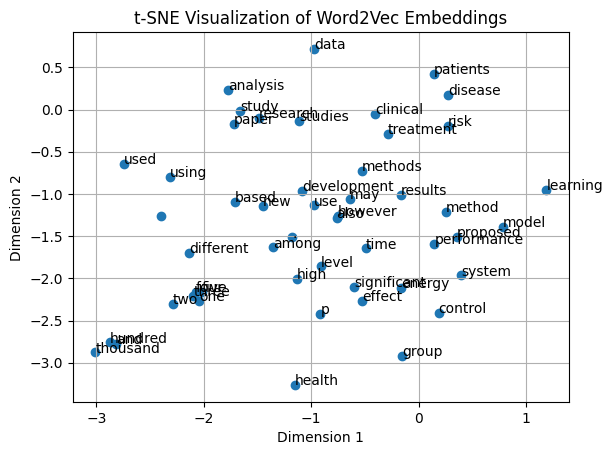

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(word_vectors_2D[:, 0], word_vectors_2D[:, 1])

# Label each point with the corresponding word
for i, word in enumerate(words_to_visualize):
    plt.annotate(word, (word_vectors_2D[i, 0], word_vectors_2D[i, 1]))

plt.title('t-SNE Visualization of Word2Vec Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()
